In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class GridWorld(object):
    def __init__(self):
        
        ### Attributes defining the Gridworld #######
        # Shape of the gridworld
        self.shape = (4,4)
        
        # Locations of the obstacles
        self.obstacle_locs = [(1,2),(2,0),(3,0),(3,1),(3,3)]
        
        # Locations for the absorbing states
        self.absorbing_locs = [(0,1),(3,2)]
        
        # Rewards for each of the absorbing states 
        self.special_rewards = [10, -100] #corresponds to each of the absorbing_locs
        
        # Reward for all the other states
        self.default_reward = -1
        
        # Starting location
        self.starting_loc = (0,0)
        
        # Action names
        self.action_names = ['N','E','S','W']
        
        # Number of actions
        self.action_size = len(self.action_names)
        
        
        # Randomizing action results: [1 0 0 0] to no Noise in the action results.
        self.action_randomizing_array = [0.7, 0.1, 0.1 , 0.1]
        
        ############################################
    
    
    
        #### Internal State  ####
        
    
        # Get attributes defining the world
        state_size, T, R, pi, absorbing, locs = self.build_grid_world()
        
        # Number of valid states in the gridworld (there are 11 of them)
        self.state_size = state_size
        
        # Transition operator (3D tensor)
        self.T = T
        
        # Reward function (3D tensor)
        self.R = R
        
        
        # Probability function for stochasticity (2D tensor)
        self.pi = pi
        
        # Absorbing states
        self.absorbing = absorbing
        
        # The locations of the valid states
        self.locs = locs
        
        # Number of the starting state
        self.starting_state = self.loc_to_state(self.starting_loc, locs);
        
        # Locating the initial state
        self.initial = np.zeros((1,len(locs)));
        self.initial[0,self.starting_state] = 1
        
        
        # Placing the walls on a bitmap
        self.walls = np.zeros(self.shape);
        for ob in self.obstacle_locs:
            self.walls[ob]=1
            
        # Placing the absorbers on a grid for illustration
        self.absorbers = np.zeros(self.shape)
        for ab in self.absorbing_locs:
            self.absorbers[ab] = -1
        
        # Placing the rewarders on a grid for illustration
        self.rewarders = np.zeros(self.shape)
        for i, rew in enumerate(self.absorbing_locs):
            self.rewarders[rew] = self.special_rewards[i]
        
        #Illustrating the grid world
        self.paint_maps()
        ################################
    
    
    
    
    
    ####### Getters ###########
    
    def get_transition_matrix(self):
        return self.T
    
    def get_reward_matrix(self):
        return self.R
    
    def get_probability_matrix(self):
        return self.pi
    
    
    ########################
    
    ####### Methods #########
    
    
    def value_iteration(self, discount = 0.3, threshold = 0.0001):
        V = np.zeros(self.state_size)
        
        T = self.get_transition_matrix()
        R = self.get_reward_matrix()
        
        ####
        pi = self.get_probability_matrix()
        
        epochs = 0
        while True:
            epochs+=1
            delta = 0

            for state_idx in range(self.state_size):
                if(self.absorbing[0,state_idx]):
                    continue 
                    
                v = V[state_idx]

                Q = np.zeros(4)
                for state_idx_prime in range(self.state_size):
                    Q +=  pi[state_idx,:]*T[state_idx_prime,state_idx,:] * (R[state_idx_prime,state_idx, :] + discount * V[state_idx_prime])
                    ########### added P
                    
                V[state_idx]= np.max(Q)
                delta = max(delta,np.abs(v - V[state_idx]))
                
            if(delta<threshold):
                optimal_policy = np.zeros((self.state_size, self.action_size))
                for state_idx in range(self.state_size):
                    Q = np.zeros(4)
                    for state_idx_prime in range(self.state_size):
                        Q += pi[state_idx,:]*T[state_idx_prime,state_idx,:] * (R[state_idx_prime,state_idx, :] + discount * V[state_idx_prime])
                    
                    optimal_policy[state_idx, np.argmax(Q)]=1

                
                return optimal_policy,epochs


    
    def policy_iteration(self, discount=0.3, threshold = 0.0001):
        policy= np.zeros((self.state_size, self.action_size))
        policy[:,0] = 1
        
        T = self.get_transition_matrix()
        R = self.get_reward_matrix()
        
        ########
        pi = self.get_probability_matrix()
        
        epochs =0
        while True: 
            V, epochs_eval = self.policy_evaluation(policy, threshold, discount)
            
            epochs+=epochs_eval
            #Policy iteration
            policy_stable = True
            
            for state_idx in range(policy.shape[0]):
                if(self.absorbing[0,state_idx]):
                    continue 
                    
                old_action = np.argmax(policy[state_idx,:])
                
                Q = np.zeros(4)
                for state_idx_prime in range(policy.shape[0]):
                    Q += pi[state_idx,:] * T[state_idx_prime,state_idx,:] * (R[state_idx_prime,state_idx, :] + discount * V[state_idx_prime])
                   
                ####### Added P, 2D vector consisting of pi(s,a)
                
                new_policy = np.zeros(4)
                new_policy[np.argmax(Q)]=1
                policy[state_idx] = new_policy
                
                if(old_action !=np.argmax(policy[state_idx])):
                    policy_stable = False
            
            if(policy_stable):
                return V, policy,epochs
                
                
                
        
    
    def policy_evaluation(self, policy, threshold, discount):
        
        # Make sure delta is bigger than the threshold to start with
        delta= 2*threshold
        
        #Get the reward and transition matrices
        R = self.get_reward_matrix()
        T = self.get_transition_matrix()
        
        
        ###
        pi = self.get_probability_matrix()

        
        # The value is initialised at 0
        V = np.zeros(policy.shape[0])
        # Make a deep copy of the value array to hold the update during the evaluation
        Vnew = np.copy(V)
        
        epoch = 0
        # While the Value has not yet converged do:
        while delta>threshold:
            epoch += 1
            for state_idx in range(policy.shape[0]):
                # If it is one of the absorbing states, ignore
                if(self.absorbing[0,state_idx]):
                    continue   
                
                # Accumulator variable for the Value of a state
                tmpV = 0
                for action_idx in range(policy.shape[1]):
                    # Accumulator variable for the State-Action Value
                    tmpQ = 0
                    for state_idx_prime in range(policy.shape[0]):
                        tmpQ = tmpQ + pi[state_idx,action_idx]*T[state_idx_prime,state_idx,action_idx] * (R[state_idx_prime,state_idx, action_idx] + discount * V[state_idx_prime])
                    
                    tmpV += policy[state_idx,action_idx] * tmpQ
                    
                # Update the value of the state
                Vnew[state_idx] = tmpV
            
            # After updating the values of all states, update the delta
            delta =  max(abs(Vnew-V))
            # and save the new value into the old
            V=np.copy(Vnew)
            
        return V, epoch
    
    def draw_deterministic_policy(self, Policy):
        # Draw a deterministic policy
        # The policy needs to be a np array of 11 values between 0 and 3 with
        # 0 -> N, 1->E, 2->S, 3->W
        plt.figure()
        plt.imshow(self.walls+ self.rewarders + self.absorbers)
        plt.imshow(self.walls)
        
        #plt.hold('on')
        for state, action in enumerate(Policy):
            if(self.absorbing[0,state]):
                continue
            arrows = [r"$\uparrow$",r"$\rightarrow$", r"$\downarrow$", r"$\leftarrow$"]
            action_arrow = arrows[action]
            location = self.locs[state]
            plt.text(location[1], location[0], action_arrow, ha='center', va='center', color='b', size='50')
    
        plt.show()
    ##########################
    
    
    ########### Internal Helper Functions #####################
    def paint_maps(self):
        plt.figure()
        plt.subplot(1,3,1)
        plt.imshow(self.walls)
        plt.subplot(1,3,2)
        plt.imshow(self.absorbers)
        plt.subplot(1,3,3)
        plt.imshow(self.rewarders) 
        plt.show()
        
    def build_grid_world(self):
        # Get the locations of all the valid states, the neighbours of each state (by state number),
        # and the absorbing states (array of 0's with ones in the absorbing states)
        locations, neighbours, absorbing_states = self.get_topology()
        
        # Get the number of states
        S = len(locations)
        
        # Initialise the transition matrix
        T = np.zeros((S,S,4))
        
        ## Initialise the probability matrix
        pi = np.zeros((S,4))  ### add
        
        ##probability matrix is based on action-state pairs
        ##if the action and outcome is the samethen p=0.3
        p_constant = 0.3
        
        for action in range(4):
            for effect in range(4):
                
                # Randomize the outcome of taking an action. is it random tho......
                
                # outcome = 
                
                outcome = (action+effect+1) % 4
                if outcome == 0:
                    outcome = 3
                else:
                    outcome -= 1
    
                # Fill the transition matrix
                prob = self.action_randomizing_array[effect]
                for prior_state in range(S):
                    post_state = neighbours[prior_state, outcome]
                    post_state = int(post_state)
                    T[post_state,prior_state,action] = T[post_state,prior_state,action]+prob
                
                    ##### Fill the probability matrix
                    if action == effect: 
                        pi[prior_state,action] = p_constant
                    
                    else:
                        pi[prior_state,action] = (1-p_constant)/3
    
        # Build the reward matrix
        R = self.default_reward*np.ones((S,S,4))
        for i, sr in enumerate(self.special_rewards):
            post_state = self.loc_to_state(self.absorbing_locs[i],locations)
            R[post_state,:,:]= sr
        
        return S, T, R, pi, absorbing_states,locations
    
    def get_topology(self):
        height = self.shape[0]
        width = self.shape[1]
        
        index = 1 
        locs = []
        neighbour_locs = []
        
        for i in range(height):
            for j in range(width):
                # Get the locaiton of each state
                loc = (i,j)
                
                #And append it to the valid state locations if it is a valid state (ie not absorbing)
                if(self.is_location(loc)):
                    locs.append(loc)
                    
                    # Get an array with the neighbours of each state, in terms of locations
                    local_neighbours = [self.get_neighbour(loc,direction) for direction in ['nr','ea','so', 'we']]
                    neighbour_locs.append(local_neighbours)
                
        # translate neighbour lists from locations to states
        num_states = len(locs)
        state_neighbours = np.zeros((num_states,4))
        
        for state in range(num_states):
            for direction in range(4):
                # Find neighbour location
                nloc = neighbour_locs[state][direction]
                
                # Turn location into a state number
                nstate = self.loc_to_state(nloc,locs)
      
                # Insert into neighbour matrix
                state_neighbours[state,direction] = nstate;
                
    
        # Translate absorbing locations into absorbing state indices
        absorbing = np.zeros((1,num_states))
        for a in self.absorbing_locs:
            absorbing_state = self.loc_to_state(a,locs)
            absorbing[0,absorbing_state] =1
        
        return locs, state_neighbours, absorbing 

    def loc_to_state(self,loc,locs):
        #takes list of locations and gives index corresponding to input loc
        return locs.index(tuple(loc))
        #return locs.index(loc)


    def is_location(self, loc):
        # It is a valid location if it is in grid and not obstacle
        if(loc[0]<0 or loc[1]<0 or loc[0]>self.shape[0]-1 or loc[1]>self.shape[1]-1):
            return False
        elif(loc in self.obstacle_locs):
            return False
        else:
             return True
            
    def get_neighbour(self,loc,direction):
        #Find the valid neighbours (ie that are in the grif and not obstacle)
        i = loc[0]
        j = loc[1]
        
        nr = (i-1,j)
        ea = (i,j+1)
        so = (i+1,j)
        we = (i,j-1)
        
        # If the neighbour is a valid location, accept it, otherwise, stay put
        if(direction == 'nr' and self.is_location(nr)):
            return nr
        elif(direction == 'ea' and self.is_location(ea)):
            return ea
        elif(direction == 'so' and self.is_location(so)):
            return so
        elif(direction == 'we' and self.is_location(we)):
            return we
        else:
            #default is to return to the same location
            return loc
        
###########################################         
    

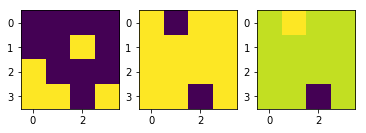

The Policy is : [[0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]]
The value of that policy is :[ 0.42205576  0.          0.53469987 -0.25276722 -0.24464248  0.40549623
 -0.2723888  -0.37087583 -6.31873698 -0.40203814  0.        ]
It took 4 epochs


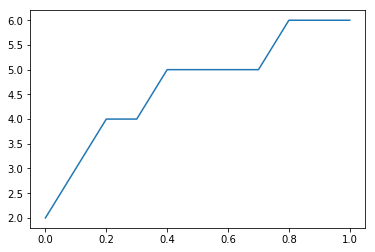

The value of the optimal policy using policy iteration is [ 1.58448894  0.          2.0452249  -0.17655524 -0.14674336  1.57207295
 -0.24731843 -0.17680708 -2.57569568 -0.26722404  0.        ]:
The optimal policy using policy iteration is [[0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]]
The number of epochs for convergence are 14
The optimal policy using value iteration is [[0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]]
The number of epocs for convergence is 4


In [3]:
grid = GridWorld()

### Question 1 : Change the policy here:
Policy= np.zeros((grid.state_size, grid.action_size))
Policy = Policy + 0.25
print("The Policy is : {}".format(Policy))

val, epochs = grid.policy_evaluation(Policy,0.001,0.3)
print("The value of that policy is :{}".format(val))
print("It took {} epochs".format(epochs))


gamma_range = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
epochs_needed = []
for gamma in gamma_range:
    val, epochs = grid.policy_evaluation(Policy,0.001,gamma)
    epochs_needed.append(epochs)
    
plt.figure()
plt.plot(gamma_range,epochs_needed)
plt.show()


V_opt, pol_opt, epochs = grid.policy_iteration()
print("The value of the optimal policy using policy iteration is {}:".format(V_opt))
print("The optimal policy using policy iteration is {}".format(pol_opt))
print("The number of epochs for convergence are {}".format(epochs))


pol_opt2, epochs = grid.value_iteration()
print("The optimal policy using value iteration is {}".format(pol_opt2))
print("The number of epocs for convergence is {}".format(epochs))


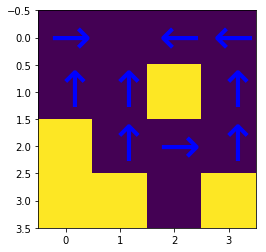

In [4]:
# Using draw_deterministic_policy to illustrate some arbitracy policy.
Policy2 = np.array([np.argmax(pol_opt[row,:]) for row in range(grid.state_size)])


grid.draw_deterministic_policy(Policy2)

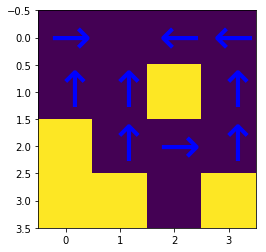

In [5]:


# Using draw_deterministic_policy to illustrate optimal policy.



Optimal_Policy = np.array([np.argmax(pol_opt2[row,:]) for row in range(0,grid.state_size)])
grid.draw_deterministic_policy(Optimal_Policy)

In [6]:
## changing to no noise

In [7]:
class GridWorld(object):
    def __init__(self):
        
        ### Attributes defining the Gridworld #######
        # Shape of the gridworld
        self.shape = (4,4)
        
        # Locations of the obstacles
        self.obstacle_locs = [(1,2),(2,0),(3,0),(3,1),(3,3)]
        
        # Locations for the absorbing states
        self.absorbing_locs = [(0,1),(3,2)]
        
        # Rewards for each of the absorbing states 
        self.special_rewards = [10, -100] #corresponds to each of the absorbing_locs
        
        # Reward for all the other states
        self.default_reward = -1
        
        # Starting location
        self.starting_loc = (0,0)
        
        # Action names
        self.action_names = ['N','E','S','W']
        
        # Number of actions
        self.action_size = len(self.action_names)
        
        
        # Randomizing action results: [1 0 0 0] to no Noise in the action results.
        self.action_randomizing_array = [1, 0, 0 , 0]
        
        ############################################
    
    
    
        #### Internal State  ####
        
    
        # Get attributes defining the world
        state_size, T, R, pi, absorbing, locs = self.build_grid_world()
        
        # Number of valid states in the gridworld (there are 11 of them)
        self.state_size = state_size
        
        # Transition operator (3D tensor)
        self.T = T
        
        # Reward function (3D tensor)
        self.R = R
        
        
        # Probability function for stochasticity (2D tensor)
        self.pi = pi
        
        # Absorbing states
        self.absorbing = absorbing
        
        # The locations of the valid states
        self.locs = locs
        
        # Number of the starting state
        self.starting_state = self.loc_to_state(self.starting_loc, locs);
        
        # Locating the initial state
        self.initial = np.zeros((1,len(locs)));
        self.initial[0,self.starting_state] = 1
        
        
        # Placing the walls on a bitmap
        self.walls = np.zeros(self.shape);
        for ob in self.obstacle_locs:
            self.walls[ob]=1
            
        # Placing the absorbers on a grid for illustration
        self.absorbers = np.zeros(self.shape)
        for ab in self.absorbing_locs:
            self.absorbers[ab] = -1
        
        # Placing the rewarders on a grid for illustration
        self.rewarders = np.zeros(self.shape)
        for i, rew in enumerate(self.absorbing_locs):
            self.rewarders[rew] = self.special_rewards[i]
        
        #Illustrating the grid world
        self.paint_maps()
        ################################
    
    
    
    
    
    ####### Getters ###########
    
    def get_transition_matrix(self):
        return self.T
    
    def get_reward_matrix(self):
        return self.R
    
    def get_probability_matrix(self):
        return self.pi
    
    
    ########################
    
    ####### Methods #########
    
    
    def value_iteration(self, discount = 0.3, threshold = 0.0001):
        V = np.zeros(self.state_size)
        
        T = self.get_transition_matrix()
        R = self.get_reward_matrix()
        
        ####
        pi = self.get_probability_matrix()
        
        epochs = 0
        while True:
            epochs+=1
            delta = 0

            for state_idx in range(self.state_size):
                if(self.absorbing[0,state_idx]):
                    continue 
                    
                v = V[state_idx]

                Q = np.zeros(4)
                for state_idx_prime in range(self.state_size):
                    Q +=  pi[state_idx,:]*T[state_idx_prime,state_idx,:] * (R[state_idx_prime,state_idx, :] + discount * V[state_idx_prime])
                    ########### added P
                    
                V[state_idx]= np.max(Q)
                delta = max(delta,np.abs(v - V[state_idx]))
                
            if(delta<threshold):
                optimal_policy = np.zeros((self.state_size, self.action_size))
                for state_idx in range(self.state_size):
                    Q = np.zeros(4)
                    for state_idx_prime in range(self.state_size):
                        Q += pi[state_idx,:]*T[state_idx_prime,state_idx,:] * (R[state_idx_prime,state_idx, :] + discount * V[state_idx_prime])
                    
                    optimal_policy[state_idx, np.argmax(Q)]=1

                
                return optimal_policy,epochs


    
    def policy_iteration(self, discount=0.3, threshold = 0.0001):
        policy= np.zeros((self.state_size, self.action_size))
        policy[:,0] = 1
        
        T = self.get_transition_matrix()
        R = self.get_reward_matrix()
        
        ########
        pi = self.get_probability_matrix()
        
        epochs =0
        while True: 
            V, epochs_eval = self.policy_evaluation(policy, threshold, discount)
            
            epochs+=epochs_eval
            #Policy iteration
            policy_stable = True
            
            for state_idx in range(policy.shape[0]):
                if(self.absorbing[0,state_idx]):
                    continue 
                    
                old_action = np.argmax(policy[state_idx,:])
                
                Q = np.zeros(4)
                for state_idx_prime in range(policy.shape[0]):
                    Q += pi[state_idx,:] * T[state_idx_prime,state_idx,:] * (R[state_idx_prime,state_idx, :] + discount * V[state_idx_prime])
                   
                ####### Added P, 2D vector consisting of pi(s,a)
                
                new_policy = np.zeros(4)
                new_policy[np.argmax(Q)]=1
                policy[state_idx] = new_policy
                
                if(old_action !=np.argmax(policy[state_idx])):
                    policy_stable = False
            
            if(policy_stable):
                return V, policy,epochs
                
                
                
        
    
    def policy_evaluation(self, policy, threshold, discount):
        
        # Make sure delta is bigger than the threshold to start with
        delta= 2*threshold
        
        #Get the reward and transition matrices
        R = self.get_reward_matrix()
        T = self.get_transition_matrix()
        
        
        ###
        pi = self.get_probability_matrix()

        
        # The value is initialised at 0
        V = np.zeros(policy.shape[0])
        # Make a deep copy of the value array to hold the update during the evaluation
        Vnew = np.copy(V)
        
        epoch = 0
        # While the Value has not yet converged do:
        while delta>threshold:
            epoch += 1
            for state_idx in range(policy.shape[0]):
                # If it is one of the absorbing states, ignore
                if(self.absorbing[0,state_idx]):
                    continue   
                
                # Accumulator variable for the Value of a state
                tmpV = 0
                for action_idx in range(policy.shape[1]):
                    # Accumulator variable for the State-Action Value
                    tmpQ = 0
                    for state_idx_prime in range(policy.shape[0]):
                        tmpQ = tmpQ + pi[state_idx,action_idx]*T[state_idx_prime,state_idx,action_idx] * (R[state_idx_prime,state_idx, action_idx] + discount * V[state_idx_prime])
                    
                    tmpV += policy[state_idx,action_idx] * tmpQ
                    
                # Update the value of the state
                Vnew[state_idx] = tmpV
            
            # After updating the values of all states, update the delta
            delta =  max(abs(Vnew-V))
            # and save the new value into the old
            V=np.copy(Vnew)
            
        return V, epoch
    
    def draw_deterministic_policy(self, Policy):
        # Draw a deterministic policy
        # The policy needs to be a np array of 11 values between 0 and 3 with
        # 0 -> N, 1->E, 2->S, 3->W
        plt.figure()
        plt.imshow(self.walls+ self.rewarders + self.absorbers)
        plt.imshow(self.walls)
        
        #plt.hold('on')
        for state, action in enumerate(Policy):
            if(self.absorbing[0,state]):
                continue
            arrows = [r"$\uparrow$",r"$\rightarrow$", r"$\downarrow$", r"$\leftarrow$"]
            action_arrow = arrows[action]
            location = self.locs[state]
            plt.text(location[1], location[0], action_arrow, ha='center', va='center', color='b', size='50')
    
        plt.show()
    ##########################
    
    
    ########### Internal Helper Functions #####################
    def paint_maps(self):
        plt.figure()
        plt.subplot(1,3,1)
        plt.imshow(self.walls)
        plt.subplot(1,3,2)
        plt.imshow(self.absorbers)
        plt.subplot(1,3,3)
        plt.imshow(self.rewarders) 
        plt.show()
        
    def build_grid_world(self):
        # Get the locations of all the valid states, the neighbours of each state (by state number),
        # and the absorbing states (array of 0's with ones in the absorbing states)
        locations, neighbours, absorbing_states = self.get_topology()
        
        # Get the number of states
        S = len(locations)
        
        # Initialise the transition matrix
        T = np.zeros((S,S,4))
        
        ## Initialise the probability matrix
        pi = np.zeros((S,4))  ### add
        
        ##probability matrix is based on action-state pairs
        ##if the action and outcome is the samethen p=0.3
        p_constant = 0.3
        
        for action in range(4):
            for effect in range(4):
                
                # Randomize the outcome of taking an action. is it random tho......
                
                # outcome = 
                
                outcome = (action+effect+1) % 4
                if outcome == 0:
                    outcome = 3
                else:
                    outcome -= 1
    
                # Fill the transition matrix
                prob = self.action_randomizing_array[effect]
                for prior_state in range(S):
                    post_state = neighbours[prior_state, outcome]
                    post_state = int(post_state)
                    T[post_state,prior_state,action] = T[post_state,prior_state,action]+prob
                
                    ##### Fill the probability matrix
                    if action == effect: 
                        pi[prior_state,action] = p_constant
                    
                    else:
                        pi[prior_state,action] = (1-p_constant)/3
    
        # Build the reward matrix
        R = self.default_reward*np.ones((S,S,4))
        for i, sr in enumerate(self.special_rewards):
            post_state = self.loc_to_state(self.absorbing_locs[i],locations)
            R[post_state,:,:]= sr
        
        return S, T, R, pi, absorbing_states,locations
    
    def get_topology(self):
        height = self.shape[0]
        width = self.shape[1]
        
        index = 1 
        locs = []
        neighbour_locs = []
        
        for i in range(height):
            for j in range(width):
                # Get the locaiton of each state
                loc = (i,j)
                
                #And append it to the valid state locations if it is a valid state (ie not absorbing)
                if(self.is_location(loc)):
                    locs.append(loc)
                    
                    # Get an array with the neighbours of each state, in terms of locations
                    local_neighbours = [self.get_neighbour(loc,direction) for direction in ['nr','ea','so', 'we']]
                    neighbour_locs.append(local_neighbours)
                
        # translate neighbour lists from locations to states
        num_states = len(locs)
        state_neighbours = np.zeros((num_states,4))
        
        for state in range(num_states):
            for direction in range(4):
                # Find neighbour location
                nloc = neighbour_locs[state][direction]
                
                # Turn location into a state number
                nstate = self.loc_to_state(nloc,locs)
      
                # Insert into neighbour matrix
                state_neighbours[state,direction] = nstate;
                
    
        # Translate absorbing locations into absorbing state indices
        absorbing = np.zeros((1,num_states))
        for a in self.absorbing_locs:
            absorbing_state = self.loc_to_state(a,locs)
            absorbing[0,absorbing_state] =1
        
        return locs, state_neighbours, absorbing 

    def loc_to_state(self,loc,locs):
        #takes list of locations and gives index corresponding to input loc
        return locs.index(tuple(loc))
        #return locs.index(loc)


    def is_location(self, loc):
        # It is a valid location if it is in grid and not obstacle
        if(loc[0]<0 or loc[1]<0 or loc[0]>self.shape[0]-1 or loc[1]>self.shape[1]-1):
            return False
        elif(loc in self.obstacle_locs):
            return False
        else:
             return True
            
    def get_neighbour(self,loc,direction):
        #Find the valid neighbours (ie that are in the grif and not obstacle)
        i = loc[0]
        j = loc[1]
        
        nr = (i-1,j)
        ea = (i,j+1)
        so = (i+1,j)
        we = (i,j-1)
        
        # If the neighbour is a valid location, accept it, otherwise, stay put
        if(direction == 'nr' and self.is_location(nr)):
            return nr
        elif(direction == 'ea' and self.is_location(ea)):
            return ea
        elif(direction == 'so' and self.is_location(so)):
            return so
        elif(direction == 'we' and self.is_location(we)):
            return we
        else:
            #default is to return to the same location
            return loc
        
########################################### 

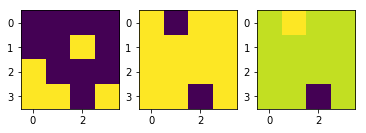

The Policy is : [[0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]]
The value of that policy is :[ 0.40350065  0.          0.59131749 -0.25021351 -0.24601286  0.38651047
 -0.27238145 -0.36541502 -6.14791314 -0.40731925  0.        ]
It took 4 epochs


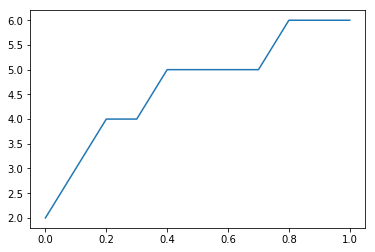

The value of the optimal policy using policy iteration is [ 2.33333333  0.          3.         -0.03       -0.07        2.33333333
 -0.23543333 -0.07       -0.25082029 -0.24981367  0.        ]:
The optimal policy using policy iteration is [[0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]]
The number of epochs for convergence are 18
The optimal policy using value iteration is [[0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]]
The number of epocs for convergence is 4


In [8]:
grid = GridWorld()

### Question 1 : Change the policy here:
Policy= np.zeros((grid.state_size, grid.action_size))
Policy = Policy + 0.25
print("The Policy is : {}".format(Policy))

val, epochs = grid.policy_evaluation(Policy,0.001,0.3)
print("The value of that policy is :{}".format(val))
print("It took {} epochs".format(epochs))


gamma_range = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
epochs_needed = []
for gamma in gamma_range:
    val, epochs = grid.policy_evaluation(Policy,0.001,gamma)
    epochs_needed.append(epochs)
    
plt.figure()
plt.plot(gamma_range,epochs_needed)
plt.show()


V_opt, pol_opt, epochs = grid.policy_iteration()
print("The value of the optimal policy using policy iteration is {}:".format(V_opt))
print("The optimal policy using policy iteration is {}".format(pol_opt))
print("The number of epochs for convergence are {}".format(epochs))


pol_opt2, epochs = grid.value_iteration()
print("The optimal policy using value iteration is {}".format(pol_opt2))
print("The number of epocs for convergence is {}".format(epochs))


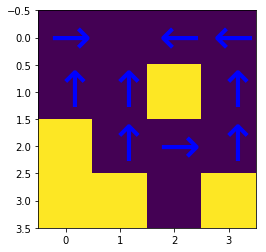

In [9]:
# Using draw_deterministic_policy to illustrate some arbitracy policy.
Policy2 = np.array([np.argmax(pol_opt[row,:]) for row in range(grid.state_size)])


grid.draw_deterministic_policy(Policy2)

In [10]:
### MORE NOISE

In [11]:
class GridWorld(object):
    def __init__(self):
        
        ### Attributes defining the Gridworld #######
        # Shape of the gridworld
        self.shape = (4,4)
        
        # Locations of the obstacles
        self.obstacle_locs = [(1,2),(2,0),(3,0),(3,1),(3,3)]
        
        # Locations for the absorbing states
        self.absorbing_locs = [(0,1),(3,2)]
        
        # Rewards for each of the absorbing states 
        self.special_rewards = [10, -100] #corresponds to each of the absorbing_locs
        
        # Reward for all the other states
        self.default_reward = -1
        
        # Starting location
        self.starting_loc = (0,0)
        
        # Action names
        self.action_names = ['N','E','S','W']
        
        # Number of actions
        self.action_size = len(self.action_names)
        
        
        # Randomizing action results: [1 0 0 0] to no Noise in the action results.
        self.action_randomizing_array = [1, 0, 0, 0]
        
        ############################################
    
    
    
        #### Internal State  ####
        
    
        # Get attributes defining the world
        state_size, T, R, pi, absorbing, locs = self.build_grid_world()
        
        # Number of valid states in the gridworld (there are 11 of them)
        self.state_size = state_size
        
        # Transition operator (3D tensor)
        self.T = T
        
        # Reward function (3D tensor)
        self.R = R
        
        
        # Probability function for stochasticity (2D tensor)
        self.pi = pi
        
        # Absorbing states
        self.absorbing = absorbing
        
        # The locations of the valid states
        self.locs = locs
        
        # Number of the starting state
        self.starting_state = self.loc_to_state(self.starting_loc, locs);
        
        # Locating the initial state
        self.initial = np.zeros((1,len(locs)));
        self.initial[0,self.starting_state] = 1
        
        
        # Placing the walls on a bitmap
        self.walls = np.zeros(self.shape);
        for ob in self.obstacle_locs:
            self.walls[ob]=1
            
        # Placing the absorbers on a grid for illustration
        self.absorbers = np.zeros(self.shape)
        for ab in self.absorbing_locs:
            self.absorbers[ab] = -1
        
        # Placing the rewarders on a grid for illustration
        self.rewarders = np.zeros(self.shape)
        for i, rew in enumerate(self.absorbing_locs):
            self.rewarders[rew] = self.special_rewards[i]
        
        #Illustrating the grid world
        self.paint_maps()
        ################################
    
    
    
    
    
    ####### Getters ###########
    
    def get_transition_matrix(self):
        return self.T
    
    def get_reward_matrix(self):
        return self.R
    
    def get_probability_matrix(self):
        return self.pi
    
    
    ########################
    
    ####### Methods #########
    
    
    def value_iteration(self, discount = 0.3, threshold = 0.0001):
        V = np.zeros(self.state_size)
        
        T = self.get_transition_matrix()
        R = self.get_reward_matrix()
        
        ####
        pi = self.get_probability_matrix()
        
        epochs = 0
        while True:
            epochs+=1
            delta = 0

            for state_idx in range(self.state_size):
                if(self.absorbing[0,state_idx]):
                    continue 
                    
                v = V[state_idx]

                Q = np.zeros(4)
                for state_idx_prime in range(self.state_size):
                    Q +=  pi[state_idx,:]*T[state_idx_prime,state_idx,:] * (R[state_idx_prime,state_idx, :] + discount * V[state_idx_prime])
                    ########### added P
                    
                V[state_idx]= np.max(Q)
                delta = max(delta,np.abs(v - V[state_idx]))
                
            if(delta<threshold):
                optimal_policy = np.zeros((self.state_size, self.action_size))
                for state_idx in range(self.state_size):
                    Q = np.zeros(4)
                    for state_idx_prime in range(self.state_size):
                        Q += pi[state_idx,:]*T[state_idx_prime,state_idx,:] * (R[state_idx_prime,state_idx, :] + discount * V[state_idx_prime])
                    
                    optimal_policy[state_idx, np.argmax(Q)]=1

                
                return optimal_policy,epochs


    
    def policy_iteration(self, discount=0.3, threshold = 0.0001):
        policy= np.zeros((self.state_size, self.action_size))
        policy[:,0] = 1
        
        T = self.get_transition_matrix()
        R = self.get_reward_matrix()
        
        ########
        pi = self.get_probability_matrix()
        
        epochs =0
        while True: 
            V, epochs_eval = self.policy_evaluation(policy, threshold, discount)
            
            epochs+=epochs_eval
            #Policy iteration
            policy_stable = True
            
            for state_idx in range(policy.shape[0]):
                if(self.absorbing[0,state_idx]):
                    continue 
                    
                old_action = np.argmax(policy[state_idx,:])
                
                Q = np.zeros(4)
                for state_idx_prime in range(policy.shape[0]):
                    Q += pi[state_idx,:] * T[state_idx_prime,state_idx,:] * (R[state_idx_prime,state_idx, :] + discount * V[state_idx_prime])
                   
                ####### Added P, 2D vector consisting of pi(s,a)
                
                new_policy = np.zeros(4)
                new_policy[np.argmax(Q)]=1
                policy[state_idx] = new_policy
                
                if(old_action !=np.argmax(policy[state_idx])):
                    policy_stable = False
            
            if(policy_stable):
                return V, policy,epochs
                
                
                
        
    
    def policy_evaluation(self, policy, threshold, discount):
        
        # Make sure delta is bigger than the threshold to start with
        delta= 2*threshold
        
        #Get the reward and transition matrices
        R = self.get_reward_matrix()
        T = self.get_transition_matrix()
        
        
        ###
        pi = self.get_probability_matrix()

        
        # The value is initialised at 0
        V = np.zeros(policy.shape[0])
        # Make a deep copy of the value array to hold the update during the evaluation
        Vnew = np.copy(V)
        
        epoch = 0
        # While the Value has not yet converged do:
        while delta>threshold:
            epoch += 1
            for state_idx in range(policy.shape[0]):
                # If it is one of the absorbing states, ignore
                if(self.absorbing[0,state_idx]):
                    continue   
                
                # Accumulator variable for the Value of a state
                tmpV = 0
                for action_idx in range(policy.shape[1]):
                    # Accumulator variable for the State-Action Value
                    tmpQ = 0
                    for state_idx_prime in range(policy.shape[0]):
                        tmpQ = tmpQ + pi[state_idx,action_idx]*T[state_idx_prime,state_idx,action_idx] * (R[state_idx_prime,state_idx, action_idx] + discount * V[state_idx_prime])
                    
                    tmpV += policy[state_idx,action_idx] * tmpQ
                    
                # Update the value of the state
                Vnew[state_idx] = tmpV
            
            # After updating the values of all states, update the delta
            delta =  max(abs(Vnew-V))
            # and save the new value into the old
            V=np.copy(Vnew)
            
        return V, epoch
    
    def draw_deterministic_policy(self, Policy):
        # Draw a deterministic policy
        # The policy needs to be a np array of 11 values between 0 and 3 with
        # 0 -> N, 1->E, 2->S, 3->W
        plt.figure()
        plt.imshow(self.walls+ self.rewarders + self.absorbers)
        plt.imshow(self.walls)
        
        #plt.hold('on')
        for state, action in enumerate(Policy):
            if(self.absorbing[0,state]):
                continue
            arrows = [r"$\uparrow$",r"$\rightarrow$", r"$\downarrow$", r"$\leftarrow$"]
            action_arrow = arrows[action]
            location = self.locs[state]
            plt.text(location[1], location[0], action_arrow, ha='center', va='center', color='w', size='40')
    
        plt.show()
    ##########################
    
    
    ########### Internal Helper Functions #####################
    def paint_maps(self):
        plt.figure()
        plt.subplot(1,3,1)
        plt.imshow(self.walls)
        plt.subplot(1,3,2)
        plt.imshow(self.absorbers)
        plt.subplot(1,3,3)
        plt.imshow(self.rewarders) 
        plt.show()
        
    def build_grid_world(self):
        # Get the locations of all the valid states, the neighbours of each state (by state number),
        # and the absorbing states (array of 0's with ones in the absorbing states)
        locations, neighbours, absorbing_states = self.get_topology()
        
        # Get the number of states
        S = len(locations)
        
        # Initialise the transition matrix
        T = np.zeros((S,S,4))
        
        ## Initialise the probability matrix
        pi = np.zeros((S,4))  ### add
        
        ##probability matrix is based on action-state pairs
        ##if the action and outcome is the samethen p=0.3
        p_constant = 0.3
        
        for action in range(4):
            for effect in range(4):
                
                # Randomize the outcome of taking an action. is it random tho......
                
                # outcome = 
                
                outcome = (action+effect+1) % 4
                if outcome == 0:
                    outcome = 3
                else:
                    outcome -= 1
    
                # Fill the probability and transition matrix
                #prob = self.action_randomizing_array[effect] 
                
                for prior_state in range(S):
                    post_state = neighbours[prior_state, outcome]
                    post_state = int(post_state)
                    
                    if action == outcome: 
                        pi[prior_state,action] = p_constant
                        prob = p_constant
                        
                    else:
                        pi[prior_state,action] = (1-p_constant)/3
                        prob = (1-p_constant)/3
                        
                    T[post_state,prior_state,action] = T[post_state,prior_state,action]+prob
                
    
        # Build the reward matrix
        R = self.default_reward*np.ones((S,S,4))
        for i, sr in enumerate(self.special_rewards):
            post_state = self.loc_to_state(self.absorbing_locs[i],locations)
            R[post_state,:,:]= sr
        
        return S, T, R, pi, absorbing_states,locations
    
    def get_topology(self):
        height = self.shape[0]
        width = self.shape[1]
        
        index = 1 
        locs = []
        neighbour_locs = []
        
        for i in range(height):
            for j in range(width):
                # Get the locaiton of each state
                loc = (i,j)
                
                #And append it to the valid state locations if it is a valid state (ie not absorbing)
                if(self.is_location(loc)):
                    locs.append(loc)
                    
                    # Get an array with the neighbours of each state, in terms of locations
                    local_neighbours = [self.get_neighbour(loc,direction) for direction in ['nr','ea','so', 'we']]
                    neighbour_locs.append(local_neighbours)
                
        # translate neighbour lists from locations to states
        num_states = len(locs)
        state_neighbours = np.zeros((num_states,4))
        
        for state in range(num_states):
            for direction in range(4):
                # Find neighbour location
                nloc = neighbour_locs[state][direction]
                
                # Turn location into a state number
                nstate = self.loc_to_state(nloc,locs)
      
                # Insert into neighbour matrix
                state_neighbours[state,direction] = nstate;
                
    
        # Translate absorbing locations into absorbing state indices
        absorbing = np.zeros((1,num_states))
        for a in self.absorbing_locs:
            absorbing_state = self.loc_to_state(a,locs)
            absorbing[0,absorbing_state] =1
        
        return locs, state_neighbours, absorbing 

    def loc_to_state(self,loc,locs):
        #takes list of locations and gives index corresponding to input loc
        return locs.index(tuple(loc))
        #return locs.index(loc)


    def is_location(self, loc):
        # It is a valid location if it is in grid and not obstacle
        if(loc[0]<0 or loc[1]<0 or loc[0]>self.shape[0]-1 or loc[1]>self.shape[1]-1):
            return False
        elif(loc in self.obstacle_locs):
            return False
        else:
             return True
            
    def get_neighbour(self,loc,direction):
        #Find the valid neighbours (ie that are in the grif and not obstacle)
        i = loc[0]
        j = loc[1]
        
        nr = (i-1,j)
        ea = (i,j+1)
        so = (i+1,j)
        we = (i,j-1)
        
        # If the neighbour is a valid location, accept it, otherwise, stay put
        if(direction == 'nr' and self.is_location(nr)):
            return nr
        elif(direction == 'ea' and self.is_location(ea)):
            return ea
        elif(direction == 'so' and self.is_location(so)):
            return so
        elif(direction == 'we' and self.is_location(we)):
            return we
        else:
            #default is to return to the same location
            return loc
        
###########################################

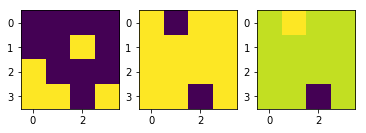

The Policy is : [[0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]]
The value of that policy is :[ 0.41902897  0.          0.41881401 -0.23877617 -0.22684287  0.40541948
 -0.25259373 -0.34555087 -6.12785596 -0.35748073  0.        ]
It took 4 epochs


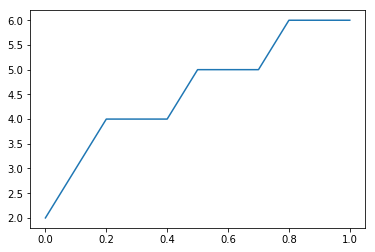

The value of the optimal policy using policy iteration is [ 0.55107186  0.          0.55084705 -0.23351059 -0.22019077  0.53650379
 -0.25208023 -0.326305   -5.72937394 -0.34342427  0.        ]:
The optimal policy using policy iteration is [[0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]]
The number of epochs for convergence are 15
The optimal policy using value iteration is [[0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]]
The number of epocs for convergence is 5


In [12]:
grid = GridWorld()

### Question 1 : Change the policy here:
Policy= np.zeros((grid.state_size, grid.action_size))
Policy = Policy + 0.25
print("The Policy is : {}".format(Policy))

val, epochs = grid.policy_evaluation(Policy,0.001,0.3)
print("The value of that policy is :{}".format(val))
print("It took {} epochs".format(epochs))


gamma_range = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
epochs_needed = []
for gamma in gamma_range:
    val, epochs = grid.policy_evaluation(Policy,0.001,gamma)
    epochs_needed.append(epochs)
    
plt.figure()
plt.plot(gamma_range,epochs_needed)
plt.show()


V_opt, pol_opt, epochs = grid.policy_iteration()
print("The value of the optimal policy using policy iteration is {}:".format(V_opt))
print("The optimal policy using policy iteration is {}".format(pol_opt))
print("The number of epochs for convergence are {}".format(epochs))


pol_opt2, epochs = grid.value_iteration()
print("The optimal policy using value iteration is {}".format(pol_opt2))
print("The number of epocs for convergence is {}".format(epochs))


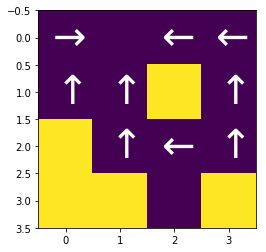

In [13]:
# OPTIMAL POLICY VIA POLICY ITERATION
Policy_POLIT = np.array([np.argmax(pol_opt[row,:]) for row in range(grid.state_size)])


grid.draw_deterministic_policy(Policy_POLIT)

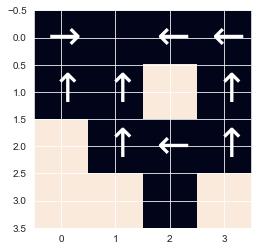

In [165]:
# OPTIMAL POLICY VIA VALUE ITERATION

Policy_VALIT = np.array([np.argmax(pol_opt2[row,:]) for row in range(grid.state_size)])


grid.draw_deterministic_policy(Policy_VALIT)

## Iterating over different p value

In [216]:
class GridWorld(object):
    def __init__(self):
        
        ### Attributes defining the Gridworld #######
        # Shape of the gridworld
        self.shape = (4,4)
        
        # Locations of the obstacles
        self.obstacle_locs = [(1,2),(2,0),(3,0),(3,1),(3,3)]
        
        # Locations for the absorbing states
        self.absorbing_locs = [(0,1),(3,2)]
        
        # Rewards for each of the absorbing states 
        self.special_rewards = [10, -100] #corresponds to each of the absorbing_locs
        
        # Reward for all the other states
        self.default_reward = -1
        
        # Starting location
        self.starting_loc = (0,0)
        
        # Action names
        self.action_names = ['N','E','S','W']
        
        # Number of actions
        self.action_size = len(self.action_names)
        
        
        # Randomizing action results: [1 0 0 0] to no Noise in the action results.
        self.action_randomizing_array = [1, 0, 0, 0]
        
        ############################################
    
    
    
        #### Internal State  ####
        
    
        # Get attributes defining the world
        state_size, T, R, pi, absorbing, locs = self.build_grid_world()
        
        # Number of valid states in the gridworld (there are 11 of them)
        self.state_size = state_size
        
        # Transition operator (3D tensor)
        self.T = T
        
        # Reward function (3D tensor)
        self.R = R
        
        
        # Probability function for stochasticity (2D tensor)
        self.pi = pi
        
        # Absorbing states
        self.absorbing = absorbing
        
        # The locations of the valid states
        self.locs = locs
        
        # Number of the starting state
        self.starting_state = self.loc_to_state(self.starting_loc, locs);
        
        # Locating the initial state
        self.initial = np.zeros((1,len(locs)));
        self.initial[0,self.starting_state] = 1
        
        
        # Placing the walls on a bitmap
        self.walls = np.zeros(self.shape);
        for ob in self.obstacle_locs:
            self.walls[ob]=1
            
        # Placing the absorbers on a grid for illustration
        self.absorbers = np.zeros(self.shape)
        for ab in self.absorbing_locs:
            self.absorbers[ab] = -1
        
        # Placing the rewarders on a grid for illustration
        self.rewarders = np.zeros(self.shape)
        for i, rew in enumerate(self.absorbing_locs):
            self.rewarders[rew] = self.special_rewards[i]
        
        #Illustrating the grid world
        self.paint_maps()
        ################################
    
    
    
    
    
    ####### Getters ###########
    
    def get_transition_matrix(self):
        return self.T
    
    def get_reward_matrix(self):
        return self.R
    
    def get_probability_matrix(self):
        return self.pi
    
    
    ########################
    
    ####### Methods #########
    
    
    def value_iteration(self, discount = 0.3, threshold = 0.0001):
        V = np.zeros(self.state_size)
        
        T = self.get_transition_matrix()
        R = self.get_reward_matrix()
        
        ####
        pi = self.get_probability_matrix()
        
        epochs = 0
        while True:
            epochs+=1
            delta = 0

            for state_idx in range(self.state_size):
                if(self.absorbing[0,state_idx]):
                    continue 
                    
                v = V[state_idx]

                Q = np.zeros(4)
                for state_idx_prime in range(self.state_size):
                    Q +=  pi[state_idx,:]*T[state_idx_prime,state_idx,:] * (R[state_idx_prime,state_idx, :] + discount * V[state_idx_prime])
                    ########### added P
                    
                V[state_idx]= np.max(Q)
                delta = max(delta,np.abs(v - V[state_idx]))
                
            if(delta<threshold):
                optimal_policy = np.zeros((self.state_size, self.action_size))
                for state_idx in range(self.state_size):
                    Q = np.zeros(4)
                    for state_idx_prime in range(self.state_size):
                        Q += pi[state_idx,:]*T[state_idx_prime,state_idx,:] * (R[state_idx_prime,state_idx, :] + discount * V[state_idx_prime])
                    
                    optimal_policy[state_idx, np.argmax(Q)]=1

                
                return optimal_policy,epochs


    
    def policy_iteration(self, discount=0.3, threshold = 0.0001):
        policy= np.zeros((self.state_size, self.action_size))
        policy[:,0] = 1
        
        T = self.get_transition_matrix()
        R = self.get_reward_matrix()
        
        ########
        pi = self.get_probability_matrix()
        
        epochs =0
        while True: 
            V, epochs_eval = self.policy_evaluation(policy, threshold, discount)
            
            epochs+=epochs_eval
            #Policy iteration
            policy_stable = True
            
            for state_idx in range(policy.shape[0]):
                if(self.absorbing[0,state_idx]):
                    continue 
                    
                old_action = np.argmax(policy[state_idx,:])
                
                Q = np.zeros(4)
                for state_idx_prime in range(policy.shape[0]):
                    Q += pi[state_idx,:] * T[state_idx_prime,state_idx,:] * (R[state_idx_prime,state_idx, :] + discount * V[state_idx_prime])
                   
                ####### Added P, 2D vector consisting of pi(s,a)
                
                new_policy = np.zeros(4)
                new_policy[np.argmax(Q)]=1
                policy[state_idx] = new_policy
                
                if(old_action !=np.argmax(policy[state_idx])):
                    policy_stable = False
            
            if(policy_stable):
                return V, policy,epochs
                
                
                
        
    
    def policy_evaluation(self, policy, threshold, discount):
        
        # Make sure delta is bigger than the threshold to start with
        delta= 2*threshold
        
        #Get the reward and transition matrices
        R = self.get_reward_matrix()
        T = self.get_transition_matrix()
        
        
        ###
        pi = self.get_probability_matrix()

        
        # The value is initialised at 0
        V = np.zeros(policy.shape[0])
        # Make a deep copy of the value array to hold the update during the evaluation
        Vnew = np.copy(V)
        
        epoch = 0
        # While the Value has not yet converged do:
        while delta>threshold:
            epoch += 1
            for state_idx in range(policy.shape[0]):
                # If it is one of the absorbing states, ignore
                if(self.absorbing[0,state_idx]):
                    continue   
                
                # Accumulator variable for the Value of a state
                tmpV = 0
                for action_idx in range(policy.shape[1]):
                    # Accumulator variable for the State-Action Value
                    tmpQ = 0
                    for state_idx_prime in range(policy.shape[0]):
                        tmpQ = tmpQ + pi[state_idx,action_idx]*T[state_idx_prime,state_idx,action_idx] * (R[state_idx_prime,state_idx, action_idx] + discount * V[state_idx_prime])
                    
                    tmpV += policy[state_idx,action_idx] * tmpQ
                    
                # Update the value of the state
                Vnew[state_idx] = tmpV
            
            # After updating the values of all states, update the delta
            delta =  max(abs(Vnew-V))
            # and save the new value into the old
            V=np.copy(Vnew)
            
        return V, epoch
    
    def draw_deterministic_policy(self, Policy):
        # Draw a deterministic policy
        # The policy needs to be a np array of 11 values between 0 and 3 with
        # 0 -> N, 1->E, 2->S, 3->W
        plt.figure()
        plt.imshow(self.walls+ self.rewarders + self.absorbers)
        plt.imshow(self.walls)
        
        #plt.hold('on')
        for state, action in enumerate(Policy):
            if(self.absorbing[0,state]):
                continue
            arrows = [r"$\uparrow$",r"$\rightarrow$", r"$\downarrow$", r"$\leftarrow$"]
            action_arrow = arrows[action]
            location = self.locs[state]
            plt.text(location[1], location[0], action_arrow, ha='center', va='center', color='w', size='40')
    
        plt.show()
    ##########################
    
    
    ########### Internal Helper Functions #####################
    def paint_maps(self):
        plt.figure()
        plt.subplot(1,3,1)
        plt.imshow(self.walls)
        plt.subplot(1,3,2)
        plt.imshow(self.absorbers)
        plt.subplot(1,3,3)
        plt.imshow(self.rewarders) 
        plt.show()
        
    def build_grid_world(self):
        # Get the locations of all the valid states, the neighbours of each state (by state number),
        # and the absorbing states (array of 0's with ones in the absorbing states)
        locations, neighbours, absorbing_states = self.get_topology()
        
        # Get the number of states
        S = len(locations)
        
        # Initialise the transition matrix
        T = np.zeros((S,S,4))
        
        ## Initialise the probability matrix
        pi = np.zeros((S,4))  ### add
        
        ##probability matrix is based on action-state pairs
        ##if the action and outcome is the samethen p=0.3
        
        ###change here for diff p!
        p_constant = 0.8
        
        for action in range(4):
            for effect in range(4):
                
                # Randomize the outcome of taking an action. is it random tho......
                
                # outcome = 
                
                outcome = (action+effect+1) % 4
                if outcome == 0:
                    outcome = 3
                else:
                    outcome -= 1
    
                # Fill the probability and transition matrix
                #prob = self.action_randomizing_array[effect] 
                
                for prior_state in range(S):
                    post_state = neighbours[prior_state, outcome]
                    post_state = int(post_state)
                    
                    if action == outcome: 
                        pi[prior_state,action] = p_constant
                        prob = p_constant
                        
                    else:
                        pi[prior_state,action] = (1-p_constant)/3
                        prob = (1-p_constant)/3
                        
                    T[post_state,prior_state,action] = T[post_state,prior_state,action]+prob
                
    
        # Build the reward matrix
        R = self.default_reward*np.ones((S,S,4))
        for i, sr in enumerate(self.special_rewards):
            post_state = self.loc_to_state(self.absorbing_locs[i],locations)
            R[post_state,:,:]= sr
        
        return S, T, R, pi, absorbing_states,locations
    
    def get_topology(self):
        height = self.shape[0]
        width = self.shape[1]
        
        index = 1 
        locs = []
        neighbour_locs = []
        
        for i in range(height):
            for j in range(width):
                # Get the locaiton of each state
                loc = (i,j)
                
                #And append it to the valid state locations if it is a valid state (ie not absorbing)
                if(self.is_location(loc)):
                    locs.append(loc)
                    
                    # Get an array with the neighbours of each state, in terms of locations
                    local_neighbours = [self.get_neighbour(loc,direction) for direction in ['nr','ea','so', 'we']]
                    neighbour_locs.append(local_neighbours)
                
        # translate neighbour lists from locations to states
        num_states = len(locs)
        state_neighbours = np.zeros((num_states,4))
        
        for state in range(num_states):
            for direction in range(4):
                # Find neighbour location
                nloc = neighbour_locs[state][direction]
                
                # Turn location into a state number
                nstate = self.loc_to_state(nloc,locs)
      
                # Insert into neighbour matrix
                state_neighbours[state,direction] = nstate;
                
    
        # Translate absorbing locations into absorbing state indices
        absorbing = np.zeros((1,num_states))
        for a in self.absorbing_locs:
            absorbing_state = self.loc_to_state(a,locs)
            absorbing[0,absorbing_state] =1
        
        return locs, state_neighbours, absorbing 

    def loc_to_state(self,loc,locs):
        #takes list of locations and gives index corresponding to input loc
        return locs.index(tuple(loc))
        #return locs.index(loc)


    def is_location(self, loc):
        # It is a valid location if it is in grid and not obstacle
        if(loc[0]<0 or loc[1]<0 or loc[0]>self.shape[0]-1 or loc[1]>self.shape[1]-1):
            return False
        elif(loc in self.obstacle_locs):
            return False
        else:
             return True
            
    def get_neighbour(self,loc,direction):
        #Find the valid neighbours (ie that are in the grif and not obstacle)
        i = loc[0]
        j = loc[1]
        
        nr = (i-1,j)
        ea = (i,j+1)
        so = (i+1,j)
        we = (i,j-1)
        
        # If the neighbour is a valid location, accept it, otherwise, stay put
        if(direction == 'nr' and self.is_location(nr)):
            return nr
        elif(direction == 'ea' and self.is_location(ea)):
            return ea
        elif(direction == 'so' and self.is_location(so)):
            return so
        elif(direction == 'we' and self.is_location(we)):
            return we
        else:
            #default is to return to the same location
            return loc
        
###########################################

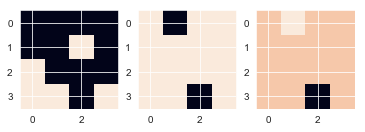

The Policy is : [[0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]]
The value of that policy is :[ 0.11751083  0.          0.11750625 -0.06709    -0.06615792  0.11654208
 -0.06806333 -0.07546667 -1.72605417 -0.07639875  0.        ]
It took 3 epochs


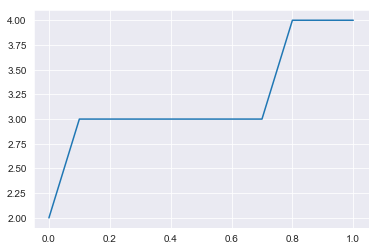

The value of the optimal policy using policy iteration is [ 0.52131312  0.          0.52131207 -0.05857237 -0.0577857   0.5205381
 -0.06787633 -0.0591737  -0.50838279 -0.06861352  0.        ]:
The optimal policy using policy iteration is [[0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]]
The number of epochs for convergence are 12
The optimal policy using value iteration is [[0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]]
The number of epocs for convergence is 3


In [217]:
grid = GridWorld()

### Question 1 : Change the policy here:
Policy= np.zeros((grid.state_size, grid.action_size))
Policy = Policy + 0.25
print("The Policy is : {}".format(Policy))

val, epochs = grid.policy_evaluation(Policy,0.001,0.3)
print("The value of that policy is :{}".format(val))
print("It took {} epochs".format(epochs))


gamma_range = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
epochs_needed = []
for gamma in gamma_range:
    val, epochs = grid.policy_evaluation(Policy,0.001,gamma)
    epochs_needed.append(epochs)
    
plt.figure()
plt.plot(gamma_range,epochs_needed)
plt.show()


V_opt, pol_opt, epochs = grid.policy_iteration()
print("The value of the optimal policy using policy iteration is {}:".format(V_opt))
print("The optimal policy using policy iteration is {}".format(pol_opt))
print("The number of epochs for convergence are {}".format(epochs))


pol_opt2, epochs = grid.value_iteration()
print("The optimal policy using value iteration is {}".format(pol_opt2))
print("The number of epocs for convergence is {}".format(epochs))


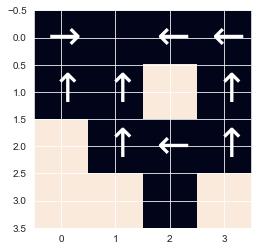

In [218]:
# OPTIMAL POLICY VIA VALUE ITERATION

Policy_VALIT = np.array([np.argmax(pol_opt2[row,:]) for row in range(grid.state_size)])


grid.draw_deterministic_policy(Policy_VALIT)

## iterating over different gamma vals

In [208]:
class GridWorld(object):
    def __init__(self):
        
        ### Attributes defining the Gridworld #######
        # Shape of the gridworld
        self.shape = (4,4)
        
        # Locations of the obstacles
        self.obstacle_locs = [(1,2),(2,0),(3,0),(3,1),(3,3)]
        
        # Locations for the absorbing states
        self.absorbing_locs = [(0,1),(3,2)]
        
        # Rewards for each of the absorbing states 
        self.special_rewards = [10, -100] #corresponds to each of the absorbing_locs
        
        # Reward for all the other states
        self.default_reward = -1
        
        # Starting location
        self.starting_loc = (0,0)
        
        # Action names
        self.action_names = ['N','E','S','W']
        
        # Number of actions
        self.action_size = len(self.action_names)
        
        
        # Randomizing action results: [1 0 0 0] to no Noise in the action results.
        self.action_randomizing_array = [1, 0, 0, 0]
        
        ############################################
    
    
    
        #### Internal State  ####
        
    
        # Get attributes defining the world
        state_size, T, R, pi, absorbing, locs = self.build_grid_world()
        
        # Number of valid states in the gridworld (there are 11 of them)
        self.state_size = state_size
        
        # Transition operator (3D tensor)
        self.T = T
        
        # Reward function (3D tensor)
        self.R = R
        
        
        # Probability function for stochasticity (2D tensor)
        self.pi = pi
        
        # Absorbing states
        self.absorbing = absorbing
        
        # The locations of the valid states
        self.locs = locs
        
        # Number of the starting state
        self.starting_state = self.loc_to_state(self.starting_loc, locs);
        
        # Locating the initial state
        self.initial = np.zeros((1,len(locs)));
        self.initial[0,self.starting_state] = 1
        
        
        # Placing the walls on a bitmap
        self.walls = np.zeros(self.shape);
        for ob in self.obstacle_locs:
            self.walls[ob]=1
            
        # Placing the absorbers on a grid for illustration
        self.absorbers = np.zeros(self.shape)
        for ab in self.absorbing_locs:
            self.absorbers[ab] = -1
        
        # Placing the rewarders on a grid for illustration
        self.rewarders = np.zeros(self.shape)
        for i, rew in enumerate(self.absorbing_locs):
            self.rewarders[rew] = self.special_rewards[i]
        
        #Illustrating the grid world
        self.paint_maps()
        ################################
    
    
    
    
    
    ####### Getters ###########
    
    def get_transition_matrix(self):
        return self.T
    
    def get_reward_matrix(self):
        return self.R
    
    def get_probability_matrix(self):
        return self.pi
    
    
    ########################
    
    ####### Methods #########
    
    ##change gamma
    def value_iteration(self, discount = 0.3, threshold = 0.0001):
        V = np.zeros(self.state_size)
        
        T = self.get_transition_matrix()
        R = self.get_reward_matrix()
        
        ####
        pi = self.get_probability_matrix()
        
        epochs = 0
        while True:
            epochs+=1
            delta = 0

            for state_idx in range(self.state_size):
                if(self.absorbing[0,state_idx]):
                    continue 
                    
                v = V[state_idx]

                Q = np.zeros(4)
                for state_idx_prime in range(self.state_size):
                    Q +=  pi[state_idx,:]*T[state_idx_prime,state_idx,:] * (R[state_idx_prime,state_idx, :] + discount * V[state_idx_prime])
                    ########### added P
                    
                V[state_idx]= np.max(Q)
                delta = max(delta,np.abs(v - V[state_idx]))
                
            if(delta<threshold):
                optimal_policy = np.zeros((self.state_size, self.action_size))
                for state_idx in range(self.state_size):
                    Q = np.zeros(4)
                    for state_idx_prime in range(self.state_size):
                        Q += pi[state_idx,:]*T[state_idx_prime,state_idx,:] * (R[state_idx_prime,state_idx, :] + discount * V[state_idx_prime])
                    
                    optimal_policy[state_idx, np.argmax(Q)]=1

                
                return optimal_policy,epochs

    ##change gamma here
    
    def policy_iteration(self, discount=0.3, threshold = 0.0001):
        policy= np.zeros((self.state_size, self.action_size))
        policy[:,0] = 1
        
        T = self.get_transition_matrix()
        R = self.get_reward_matrix()
        
        ########
        pi = self.get_probability_matrix()
        
        epochs =0
        while True: 
            V, epochs_eval = self.policy_evaluation(policy, threshold, discount)
            
            epochs+=epochs_eval
            #Policy iteration
            policy_stable = True
            
            for state_idx in range(policy.shape[0]):
                if(self.absorbing[0,state_idx]):
                    continue 
                    
                old_action = np.argmax(policy[state_idx,:])
                
                Q = np.zeros(4)
                for state_idx_prime in range(policy.shape[0]):
                    Q += pi[state_idx,:] * T[state_idx_prime,state_idx,:] * (R[state_idx_prime,state_idx, :] + discount * V[state_idx_prime])
                   
                ####### Added P, 2D vector consisting of pi(s,a)
                
                new_policy = np.zeros(4)
                new_policy[np.argmax(Q)]=1
                policy[state_idx] = new_policy
                
                if(old_action !=np.argmax(policy[state_idx])):
                    policy_stable = False
            
            if(policy_stable):
                return V, policy,epochs
                
                
                
        
    
    def policy_evaluation(self, policy, threshold, discount):
        
        # Make sure delta is bigger than the threshold to start with
        delta= 2*threshold
        
        #Get the reward and transition matrices
        R = self.get_reward_matrix()
        T = self.get_transition_matrix()
        
        
        ###
        pi = self.get_probability_matrix()

        
        # The value is initialised at 0
        V = np.zeros(policy.shape[0])
        # Make a deep copy of the value array to hold the update during the evaluation
        Vnew = np.copy(V)
        
        epoch = 0
        # While the Value has not yet converged do:
        while delta>threshold:
            epoch += 1
            for state_idx in range(policy.shape[0]):
                # If it is one of the absorbing states, ignore
                if(self.absorbing[0,state_idx]):
                    continue   
                
                # Accumulator variable for the Value of a state
                tmpV = 0
                for action_idx in range(policy.shape[1]):
                    # Accumulator variable for the State-Action Value
                    tmpQ = 0
                    for state_idx_prime in range(policy.shape[0]):
                        tmpQ = tmpQ + pi[state_idx,action_idx]*T[state_idx_prime,state_idx,action_idx] * (R[state_idx_prime,state_idx, action_idx] + discount * V[state_idx_prime])
                    
                    tmpV += policy[state_idx,action_idx] * tmpQ
                    
                # Update the value of the state
                Vnew[state_idx] = tmpV
            
            # After updating the values of all states, update the delta
            delta =  max(abs(Vnew-V))
            # and save the new value into the old
            V=np.copy(Vnew)
            
        return V, epoch
    
    def draw_deterministic_policy(self, Policy):
        # Draw a deterministic policy
        # The policy needs to be a np array of 11 values between 0 and 3 with
        # 0 -> N, 1->E, 2->S, 3->W
        plt.figure()
        plt.imshow(self.walls+ self.rewarders + self.absorbers)
        plt.imshow(self.walls)
        
        #plt.hold('on')
        for state, action in enumerate(Policy):
            if(self.absorbing[0,state]):
                continue
            arrows = [r"$\uparrow$",r"$\rightarrow$", r"$\downarrow$", r"$\leftarrow$"]
            action_arrow = arrows[action]
            location = self.locs[state]
            plt.text(location[1], location[0], action_arrow, ha='center', va='center', color='w', size='40')
    
        plt.show()
    ##########################
    
    
    ########### Internal Helper Functions #####################
    def paint_maps(self):
        plt.figure()
        plt.subplot(1,3,1)
        plt.imshow(self.walls)
        plt.subplot(1,3,2)
        plt.imshow(self.absorbers)
        plt.subplot(1,3,3)
        plt.imshow(self.rewarders) 
        plt.show()
        
    def build_grid_world(self):
        # Get the locations of all the valid states, the neighbours of each state (by state number),
        # and the absorbing states (array of 0's with ones in the absorbing states)
        locations, neighbours, absorbing_states = self.get_topology()
        
        # Get the number of states
        S = len(locations)
        
        # Initialise the transition matrix
        T = np.zeros((S,S,4))
        
        ## Initialise the probability matrix
        pi = np.zeros((S,4))  ### add
        
        ##probability matrix is based on action-state pairs
        ##if the action and outcome is the samethen p=0.3
        
        ###change here for diff p
        p_constant = 0.3
        
        for action in range(4):
            for effect in range(4):
                
                # Randomize the outcome of taking an action. is it random tho......
                
                # outcome = 
                
                outcome = (action+effect+1) % 4
                if outcome == 0:
                    outcome = 3
                else:
                    outcome -= 1
    
                # Fill the probability and transition matrix
                #prob = self.action_randomizing_array[effect] 
                
                for prior_state in range(S):
                    post_state = neighbours[prior_state, outcome]
                    post_state = int(post_state)
                    
                    if action == outcome: 
                        pi[prior_state,action] = p_constant
                        prob = p_constant
                        
                    else:
                        pi[prior_state,action] = (1-p_constant)/3
                        prob = (1-p_constant)/3
                        
                    T[post_state,prior_state,action] = T[post_state,prior_state,action]+prob
                
    
        # Build the reward matrix
        R = self.default_reward*np.ones((S,S,4))
        for i, sr in enumerate(self.special_rewards):
            post_state = self.loc_to_state(self.absorbing_locs[i],locations)
            R[post_state,:,:]= sr
        
        return S, T, R, pi, absorbing_states,locations
    
    def get_topology(self):
        height = self.shape[0]
        width = self.shape[1]
        
        index = 1 
        locs = []
        neighbour_locs = []
        
        for i in range(height):
            for j in range(width):
                # Get the locaiton of each state
                loc = (i,j)
                
                #And append it to the valid state locations if it is a valid state (ie not absorbing)
                if(self.is_location(loc)):
                    locs.append(loc)
                    
                    # Get an array with the neighbours of each state, in terms of locations
                    local_neighbours = [self.get_neighbour(loc,direction) for direction in ['nr','ea','so', 'we']]
                    neighbour_locs.append(local_neighbours)
                
        # translate neighbour lists from locations to states
        num_states = len(locs)
        state_neighbours = np.zeros((num_states,4))
        
        for state in range(num_states):
            for direction in range(4):
                # Find neighbour location
                nloc = neighbour_locs[state][direction]
                
                # Turn location into a state number
                nstate = self.loc_to_state(nloc,locs)
      
                # Insert into neighbour matrix
                state_neighbours[state,direction] = nstate;
                
    
        # Translate absorbing locations into absorbing state indices
        absorbing = np.zeros((1,num_states))
        for a in self.absorbing_locs:
            absorbing_state = self.loc_to_state(a,locs)
            absorbing[0,absorbing_state] =1
        
        return locs, state_neighbours, absorbing 

    def loc_to_state(self,loc,locs):
        #takes list of locations and gives index corresponding to input loc
        return locs.index(tuple(loc))
        #return locs.index(loc)


    def is_location(self, loc):
        # It is a valid location if it is in grid and not obstacle
        if(loc[0]<0 or loc[1]<0 or loc[0]>self.shape[0]-1 or loc[1]>self.shape[1]-1):
            return False
        elif(loc in self.obstacle_locs):
            return False
        else:
             return True
            
    def get_neighbour(self,loc,direction):
        #Find the valid neighbours (ie that are in the grif and not obstacle)
        i = loc[0]
        j = loc[1]
        
        nr = (i-1,j)
        ea = (i,j+1)
        so = (i+1,j)
        we = (i,j-1)
        
        # If the neighbour is a valid location, accept it, otherwise, stay put
        if(direction == 'nr' and self.is_location(nr)):
            return nr
        elif(direction == 'ea' and self.is_location(ea)):
            return ea
        elif(direction == 'so' and self.is_location(so)):
            return so
        elif(direction == 'we' and self.is_location(we)):
            return we
        else:
            #default is to return to the same location
            return loc
        

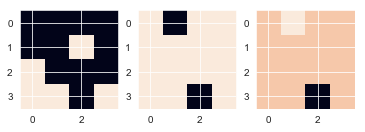

The Policy is : [[0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]]
The value of that policy is :[ 0.41902897  0.          0.41881401 -0.23877617 -0.22684287  0.40541948
 -0.25259373 -0.34555087 -6.12785596 -0.35748073  0.        ]
It took 4 epochs


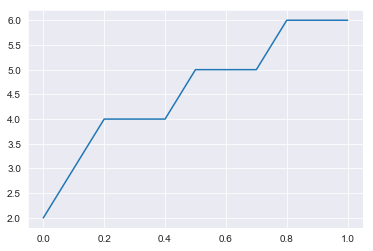

The value of the optimal policy using policy iteration is [ 0.55107186  0.          0.55084705 -0.23351059 -0.22019077  0.53650379
 -0.25208023 -0.326305   -5.72937394 -0.34342427  0.        ]:
The optimal policy using policy iteration is [[0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]]
The number of epochs for convergence are 15
The optimal policy using value iteration is [[0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]]
The number of epocs for convergence is 5


In [209]:
grid = GridWorld()

### Question 1 : Change the policy here:
Policy= np.zeros((grid.state_size, grid.action_size))
Policy = Policy + 0.25
print("The Policy is : {}".format(Policy))


##change gamma here
val, epochs = grid.policy_evaluation(Policy,0.001,0.3)
print("The value of that policy is :{}".format(val))
print("It took {} epochs".format(epochs))


gamma_range = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
epochs_needed = []
for gamma in gamma_range:
    val, epochs = grid.policy_evaluation(Policy,0.001,gamma)
    epochs_needed.append(epochs)
    
plt.figure()
plt.plot(gamma_range,epochs_needed)
plt.show()


V_opt, pol_opt, epochs = grid.policy_iteration()
print("The value of the optimal policy using policy iteration is {}:".format(V_opt))
print("The optimal policy using policy iteration is {}".format(pol_opt))
print("The number of epochs for convergence are {}".format(epochs))


pol_opt2, epochs = grid.value_iteration()
print("The optimal policy using value iteration is {}".format(pol_opt2))
print("The number of epocs for convergence is {}".format(epochs))


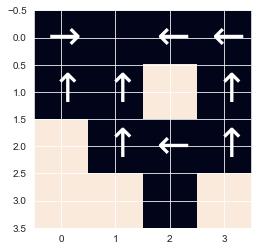

In [207]:
# OPTIMAL POLICY VIA POLICY ITERATION
Policy_POLIT = np.array([np.argmax(pol_opt[row,:]) for row in range(grid.state_size)])


grid.draw_deterministic_policy(Policy_POLIT)